# Predicting Dengue cases with XGBoost

In [1]:
#!pip install xgboost

import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Since our dataset is huge, we are going to focus on one city: Belo Horizonte

In [2]:
bh = pd.read_csv('./Dados/Datasets/Belo Horizonte.csv.gz')

In [3]:
bh.head()

,capital,data_alvo,ocorrencias_alvo,por_habitante_alvo,municipio,dt_sintoma,lag,ocorrencias,por_habitante,distancia
0,Belo Horizonte,2019-05-05,1168,46.279053,Aracaju,2016-05-01,157.0,24,3.772523,12.48
1,Belo Horizonte,2019-05-05,1168,46.279053,Aracaju,2016-05-08,156.0,40,6.286037,12.48
2,Belo Horizonte,2019-05-05,1168,46.279053,Aracaju,2016-05-15,155.0,21,3.299381,12.48
3,Belo Horizonte,2019-05-05,1168,46.279053,Aracaju,2016-05-22,154.0,35,5.497664,12.48
4,Belo Horizonte,2019-05-05,1168,46.279053,Aracaju,2016-05-29,153.0,31,4.868197,12.48


We will need some auxiliary functions.

In [4]:
# Generate training and test datasets
def split(df, outcome, seed=12345):
    y = outcome + '_alvo'
    X, y = df[['lag', outcome, 'distancia']], df[y]

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=.25,
                                                        random_state=seed)
    return(X_train, X_test, y_train, y_test)

# Get number of estimators
def get_tree(X, y, params_dict, folds=5, num_boost_round=500, early_stopping_rounds=25):
    DM_data = xgb.DMatrix(data=X, label=y)
    
    cv_results = xgb.cv(dtrain=DM_data, 
                        params=params_dict,
                        nfold=folds,
                        num_boost_round=num_boost_round,
                        early_stopping_rounds=early_stopping_rounds,
                        metrics='rmse',
                        as_pandas=True,
                        seed=12345)
    
    return(cv_results)

# Get optimal parameters
def get_hyper(X, y, params_dict, random=True, iterations=100, folds=5):
    gbm = xgb.XGBRegressor()
    
    if random:
        search_mse = RandomizedSearchCV(estimator=gbm,
                                        param_distributions=params_dict,
                                        n_iter=iterations,
                                        scoring='neg_mean_squared_error',
                                        cv=folds,
                                        verbose=1)
    else:    
        search_mse = GridSearchCV(estimator=gbm,
                                  param_grid=params_dict,
                                  scoring='neg_mean_squared_error',
                                  cv=folds,
                                  verbose=1)
    search_mse.fit(X, y)
    return(search_mse.best_params_, np.sqrt(np.abs(search_mse.best_score_)))

# Test the model
def test(Xtrain, Xtest, ytrain, ytest, params, seed):
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror',
                              params=params,
                              seed=seed)
    xg_reg.fit(Xtrain, ytrain)
    preds = xg_reg.predict(Xtest)
    
    rmse = np.sqrt(mean_squared_error(ytest, preds))
    preds_pd = pd.Series(preds)
    
    return(rmse, preds_pd)

## Training and validating of hyperparameters

In [5]:
# Split the dataset
X_train, X_test, y_train, y_test = split(bh, outcome='por_habitante')

X_train.to_csv('Dados/xtrain_bh.csv.gz')
X_test.to_csv('Dados/xtest_bh.csv.gz')
y_train.to_csv('Dados/ytrain_bh.csv.gz')
y_test.to_csv('Dados/ytest_bh.csv.gz')

Optimal number of estimators for number of cases in Belo Horizonte:
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         116.727692        0.089528      116.737166       0.369181
1         115.215674        0.089879      115.232631       0.369054
2         113.965280        0.089464      113.987312       0.367195
3         112.930238        0.086745      112.960121       0.371296
4         112.074609        0.090159      112.108745       0.368759
..               ...             ...             ...            ...
995        93.968542        0.222032       96.740807       0.271538
996        93.960077        0.221916       96.735020       0.270489
997        93.952979        0.220014       96.730040       0.273025
998        93.941756        0.221744       96.722381       0.269713
999        93.931534        0.220439       96.715532       0.269650

[1000 rows x 4 columns]


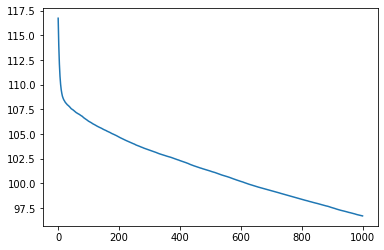

In [6]:
# Step1: Fix learning rate and number of estimators for tuning tree-based parameters
params = {'learning_rate': .1,
          'min_child_weight': 1,          
          'max_depth': 6,
          'gamma': 0,
          'subsample': 1}

best_estimators = get_tree(X_train, y_train, params_dict=params,
                            num_boost_round=1000, early_stopping_rounds=50)
print('Optimal number of estimators for number of cases in Belo Horizonte:')
print(best_estimators)

plt.plot(best_estimators.index, best_estimators['test-rmse-mean'], label='linear')
plt.show()

best_estimators.reset_index(inplace=True)
best_estimators.rename(columns={'index':'Trees', 'test-rmse-mean': 'Mean RMSE'}, 
                       inplace=True)
best_estimators.to_csv('Dados/xgboost_estimators_1.csv')

In [7]:
# Step 2: Tune max_depth and min_child_weight
params = {'learning_rate': [.1],
          'min_child_weight': [.1, .5, 1, 2, 5],          
          'max_depth': [4, 6, 8, 10],
          'n_estimators': [25],
          'gamma': [0],
          'subsample': [1]}

best_pars, best_rmse = get_hyper(X_train, y_train, random=False, iterations=5, params_dict=params)
print('Best RMSE for number of cases in Belo Horizonte:')
print(best_pars)
print(best_rmse)

# Initial results
# {'subsample': 1, 'n_estimators': 25, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0}
# RMSE: 115.55052038968748

# Refining the parameters
params = {'learning_rate': [.1],
          'min_child_weight': [1.5, 2, 2.5],          
          'max_depth': [3, 4, 5],
          'n_estimators': [25],
          'gamma': [0],
          'subsample': [1]}

best_pars, best_rmse = get_hyper(X_train, y_train, random=False, iterations=5, params_dict=params)
print('Best RMSE for number of cases in Belo Horizonte:')
print(best_pars)
print(best_rmse)

# Refined results
# {'subsample': 1, 'n_estimators': 25, 'min_child_weight': 2.5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0}
# RMSE: 115.52004363204088

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:37:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:38:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:38:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[23:47:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:47:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:47:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:48:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:48:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:48:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:48:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:48:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 17.9min finished


[23:55:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best RMSE for number of cases in Belo Horizonte:
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 25, 'subsample': 1}
102.92813225297715
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[23:55:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[23:55:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:56:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.2min finished


[23:59:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best RMSE for number of cases in Belo Horizonte:
{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2.5, 'n_estimators': 25, 'subsample': 1}
108.77967094117135


In [2]:
# Step 3: Setting the gamma parameter
params = {'learning_rate': [.1],
          'min_child_weight': [2.5],          
          'max_depth': [5],
          'n_estimators': [25],
          'gamma': [0, .1, .25, .5, 1, 2],
          'subsample': [1]}

best_pars, best_rmse = get_hyper(X_train, y_train, random=False, iterations=5, params_dict=params)
print('Best RMSE for number of cases in Belo Horizonte:')
print(best_pars)
print(best_rmse)

# Optimal gamma
# {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2.5, 'n_estimators': 25, 'subsample': 1}
# RMSE: 115.52004363204088

NameError: name 'get_hyper' is not defined

In [3]:
# Step 4: Setting the subsample and colsample_bytree parameters
params = {'learning_rate': [.1],
          'min_child_weight': [2.5],          
          'max_depth': [5],
          'n_estimators': [25],
          'gamma': [0],
          'subsample': [.3, .6, 1],
          'colsample_bytree': [.3, .6, 1]}

best_pars, best_rmse = get_hyper(X_train, y_train, random=False, iterations=5, params_dict=params)
print('Best RMSE for number of cases in Belo Horizonte:')
print(best_pars)
print(best_rmse)

# Results
# {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2.5, 'n_estimators': 25, 'subsample': 1}
# 115.52004363204088

NameError: name 'get_hyper' is not defined

In [4]:
# Step5: Lower the learning rate while increasing the number of estimators
params = {'learning_rate': .01,
          'min_child_weight': 2.5,          
          'max_depth': 5,
          'gamma': 0,
          'subsample': 1}

best_estimators = get_tree(X_train, y_train, params_dict=params,
                            num_boost_round=5000, early_stopping_rounds=50)
print('Optimal number of estimators for number of cases in Belo Horizonte:')
print(best_estimators)

plt.plot(best_estimators.index, best_estimators['test-rmse-mean'], label='linear')
plt.show()

best_estimators.reset_index(inplace=True)
best_estimators.rename(columns={'index':'Trees', 'test-rmse-mean': 'Mean RMSE'}, 
                       inplace=True)
best_estimators.to_csv('Dados/xgboost_estimators_01.csv')


NameError: name 'get_tree' is not defined

## Testing the model

In [ ]:
params = {'learning_rate': .01,
          'n_estimators': 250,
          'min_child_weight': 2.5,          
          'max_depth': 5,
          'gamma': 0,
          'subsample': 1}

rmse_test, predicted = test(X_train, X_test, y_train, y_test, 
                            params=params, 
                            seed=12345)
print('RMSE for the test dataset: % 5.2f' %(rmse_test))

df_predicted = y_test.to_frame().reset_index()
df_predicted['por_habitante_pred'] = predicted
df_predicted = df_predicted.merge(X_test.reset_index(),
                                  left_index=True,
                                  right_index=True)
df_predicted.drop('index_y', axis=1, inplace=True)
df_predicted.rename(columns={'index_x':'index'}, inplace=True)

df_predicted.to_csv('Dados/xgboost_pred.csv.gz')